# このファイルについて

擾乱に対する位置制御のために必要な燃料を推算します。

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math

In [24]:
MU = 3.986*10**5#地球重力定数[km^3/s^2]
R_po = 6600.#パーキング軌道半径[km]
Delta_i = 30.#種子島の緯度[deg]
PI = np.pi
J2 = 1082.628*10**(-6)#J2帯状調和関数係数
R_e = 6

In [25]:
alpha = 28.58
alpha = np.deg2rad(alpha)
delta_moon = 102.67*np.cos(alpha)*np.sin(alpha)
print(delta_moon)
gamma = 23.44
gamma = np.deg2rad(alpha)
delta_sun = 40.17*np.cos(gamma)*np.sin(alpha)
print(delta_sun)

43.13106201760243
19.216011456044555


# 再突入のΔｖ概算
## to do
大気とか概算なので、ちゃんと後でどっかのデータ引用した方がよい



In [28]:
G = 9.81 #重力加速度[m/s^2]
R_earth = 6378 #地球の半径[km]
SCALE_HEIGHT = 8.432#スケールハイト[km]
RHO_0 = 1.225#標準大気密度[kg/m^3]
H_reEntry = 200 #大気圏高度[km]
## すまん、ここ詰める必要あるな
v_reEntry = 5.6#再突入の速度(一例)[km/s]
gamma_reEntry = -6.0#再突入時の経路角(結構浅め)[deg]

#機体によるので、あとで
M_capcell = 16.3 #はやぶさ参照[kg]
A = 0.2 #ハヤブサよりちょい大きめ[kg]
#なんかを参照
Cd = 2.2
Cl = 0
DT = 0.01#刻み
def dominant_eq(D,L,gamma,v,r, M=M_capcell):
    gamma_rad = np.deg2rad(gamma)
    dot_r = v*np.sin(gamma_rad)
    dot_v = -D/M*10**3-G*math.sin(gamma_rad)*10**(-3)
    dotgamma_rad = L/(M*v)*10**3-G*math.cos(gamma_rad)/v*10**(-3)+v*math.cos(gamma_rad)/r
    dot_gamma = np.rad2deg(dotgamma_rad)
    return dot_r,dot_v,dot_gamma

def get_density(h):
    return RHO_0*np.exp(-h/SCALE_HEIGHT)

def get_Drag_Lift(v,rho, S=A):
    D = 1/2*rho*v**2*S*Cd
    L = 1/2*rho*v**2*S*Cl
    return D,L

def f(h, v, gamma):
    rho = get_density(h)
    D,  L = get_Drag_Lift(v, rho)
    r = h + R_earth
    dot_r, dot_v, dot_gamma = dominant_eq(D, L, gamma, v, r)
    return np.array([dot_r, dot_v, dot_gamma])

def re_entry(v_reEntey,gamma_reEntry):
    h = H_reEntry
    v = v_reEntry
    gamma = gamma_reEntry
    dynamic_pressure = 1/2 * get_density(h) * (v*10**3)**2
    t = 0
    t_lst = [t]
    h_lst = [h]
    v_lst = [v]
    gamma_lst= [gamma]
    dynamic_pressure_lst = [dynamic_pressure]
    while 0 <= h <= H_reEntry:
        k1_vector = f(h, v, gamma)*DT
        k1_r, k1_v, k1_gamma = k1_vector[0], k1_vector[1], k1_vector[2]
        k1_h = k1_r
        
        k2_vector = f(h+k1_h/2, v+k1_v/2, gamma+k1_gamma/2)*DT
        k2_r, k2_v, k2_gamma = k2_vector[0], k2_vector[1], k2_vector[2]
        k2_h = k2_r

        k3_vector = f(h+k2_h/2, v+k2_v/2, gamma+k2_gamma/2)*DT
        k3_r, k3_v, k3_gamma = k3_vector[0], k3_vector[1], k3_vector[2]
        k3_h = k3_r

        k4_vector = f(h+k3_h, v+k3_v, gamma+k3_gamma)*DT
        k4_r, k4_v, k4_gamma = k4_vector[0], k4_vector[1], k4_vector[2]
        k4_h = k4_r

        delta_r_euqual_h = (k1_r + 2.*k2_r + 2.*k3_r + k4_r)/6.
        delta_v = (k1_v + 2.*k2_v + 2.*k3_v + k4_v)/6.
        delta_gamma = (k1_gamma + 2.*k2_gamma + 2.*k3_gamma + k4_gamma)/6
        ####################################
        h += delta_r_euqual_h
        v += delta_v
        gamma += delta_gamma
        t += DT
        dynamic_pressure = 1/2 * get_density(h) * (v*10**3)**2
        t_lst.append(t)
        h_lst.append(h)
        v_lst.append(v)
        gamma_lst.append(gamma)
        dynamic_pressure_lst.append(dynamic_pressure)
    if h_lst[-1] >= H_reEntry:
        #大気に弾かれた場合
        print("カプセル帰ってこず。。。。")
    else:
        print("カプセル帰還")
        return t_lst, h_lst, v_lst, gamma_lst

カプセル帰還


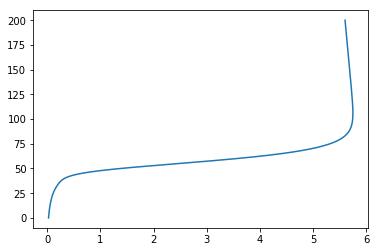

In [29]:
a, b, c, d = re_entry(v_reEntry, gamma_reEntry)
plt.plot(c, b)
plt.show()

In [20]:
#擾乱の永年項を計算
#計算量多めなので、後で直す
def gravity_perturbation_moon(r, i):
    """
    月の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_moon(float) 近地点引数の変化[deg/day]
    dot_Omega_moon(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_moon = -0.00338*np.cos(i)/n
    dot_omega_moon = 0.00169*(4-5*(np.sin(i))**2)/n
    return dot_Omega_moon, dot_omega_moon

def gravity_perturbation_sun(r, i):
    """
    太陽の重力による擾乱
    
    arg:
    r(float) 軌道長半径(円軌道の時は半径)[km]
    i(float) 軌道傾斜角[deg]
    
    return:
    dot_omega_sun(float) 近地点引数の変化[deg/day]
    dot_Omega_sun(float) 昇交点赤経の変化[deg/day]
    
    """
    i = np.deg2rad(i)
    n = np.sqrt(MU/r**3) #[rad/s]
    n *= 60*60*24 #[rad/day]
    n /= 2*PI#[周回数/day]
    dot_Omega_sun = -0.00154*np.cos(i)/n
    dot_omega_sun = 0.00077*(4-5*((np.sin(i))**2))/n
    return dot_Omega_sun, dot_omega_sun

print(gravity_perturbation_sun(6700, 28))

(-8.58944949611711e-05, 0.0001409600776584566)


In [1]:
class Orbit:
    """なんか軌道わかるとうまくいくやつ()
    to do
    外乱制御用のΔV
    """
    
    def __init__(self, r_tgt):
        """とりあえず円周回軌道半径だけ。。。"""
        self.r_tgt = r_tgt # radius of orbit
        self.delta_v_peri = None
        self.delta_v_apo = None
        self.delta_v = None
        
        self.reentry_height = 100 #地球の大気圏高度[km]
        self.v_tgt = None
    def get_delta_v_peri(self):
        """近地点でのΔv"""
        r_tgt = self.r_tgt
        v_po = np.sqrt(MU/R_po)
        v_peri_trans = np.sqrt(2*MU*r_tgt/R_po/(R_po+r_tgt))
        self.delta_v_peri = v_peri_trans - v_po

    def get_delta_v_apo(self):
        """遠地点でのΔv"""
        r_tgt = self.r_tgt
        self.v_tgt = np.sqrt(MU/r_tgt)
        v_apo_trans = np.sqrt(2*MU*R_po/r_tgt/(R_po+r_tgt))
        self.delta_v_apo = self.v_tgt-v_apo_trans
    
    def j2(self):
        """
        外乱J2項考えましょうね～～～～～～～～～～
        """
    
    def get_delta_v(self):
        """Δv全部"""
        self.get_delta_v_peri()
        self.get_delta_v_apo()
        self.delta_v = self.delta_v_apo+self.delta_v_peri
        print("Delta V: {0} [km/s]".format(self.delta_v))
        print("V at tgt: {}[km/s]".format(self.v_tgt))

In [5]:
orb = Orbit(7200.)
orb.get_delta_v()

Delta V: 0.3306925582501039 [km/s]
V at ttgt: 7.440504761849906[km/s]
